In [1]:
%pylab inline
import os
import cv2
import pickle
import numpy as np
from scipy.misc import imresize

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (14, 12)

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def reduce(img):
    return np.reshape(img, img.shape[:2])

def plot_images(images, row=1, im_prep=None, titles=None, cmap=None, figsize=(12, 12)):
    add_col = 1 if (len(images) % row) else 0
    col = (len(images) // row) + add_col
    fig, axes = subplots(row,col, subplot_kw={'xticks': [], 'yticks': []}, figsize=figsize)
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    if im_prep is None:
        im_prep = lambda x: x

    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = im_prep(images[i])
        if (len(img.shape) < 3) and cmap is None:
            cmap='gray'
        ax.imshow(img, cmap=cmap)
        if titles is not None:
            ax.set_title(titles[i])
    show()

In [3]:
test_data_path = './test_images/'

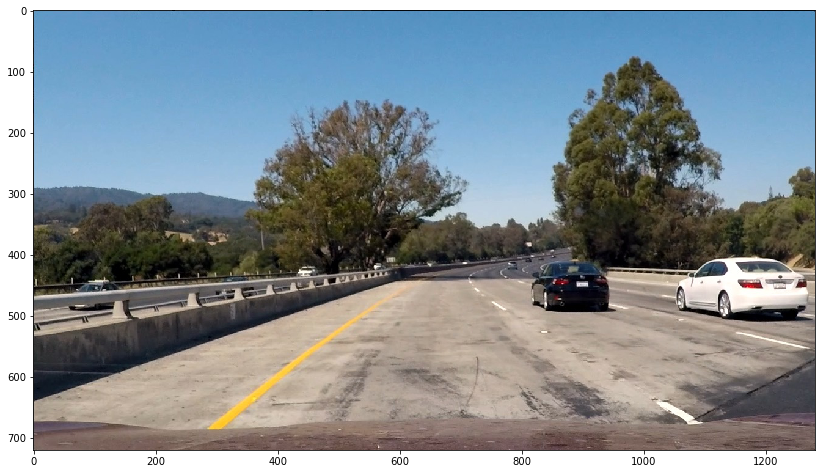

In [4]:
img = cv2.imread(test_data_path + 'test1.jpg')
imshow(bgr2rgb(img))

In [5]:
from skimage.feature import hog

## Car classifier

### Observe dataset

In [6]:
imgs = [imread('data/vehicles/GTI_Far/image0000.png'), 
        imread('data/vehicles/GTI_Left/image0009.png'),
        imread('data/vehicles/KITTI_extracted/1.png'),
        imread('data/non-vehicles/Extras/extra1.png'),
        imread('data/non-vehicles/GTI/image1.png'),
        imread('data/non-vehicles/GTI/image20.png')]

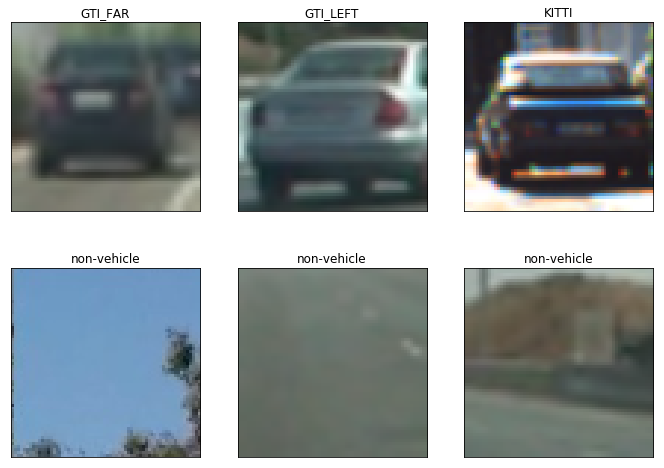

In [7]:
plot_images(imgs, row=2, titles=('GTI_FAR', 'GTI_LEFT', 'KITTI', *(['non-vehicle']*3)), figsize=(12,8))

### Extracting features

In [8]:
import image_preproc as imp

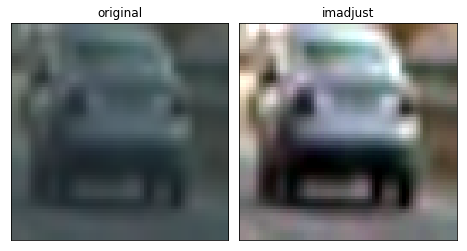

In [9]:
img = cv2.imread('data/vehicles/GTI_Far/image0030.png')
# Matlab's imadjust method
# https://stackoverflow.com/a/44611551/4875690
pimg = imp.imadjust(img)

plot_images((img, pimg), im_prep=bgr2rgb, figsize=(8,8), titles=('original', 'imadjust'))

A square root of the image normalizes it and gets uniform brightness thus reducing the effect of shadows

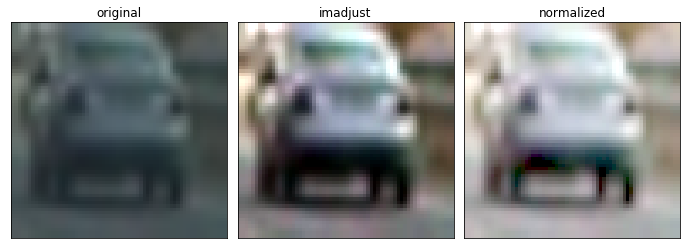

In [10]:
img_norm = (np.sqrt(pimg.astype(np.float32)/255)*255).astype(np.uint8)

plot_images((img, pimg, img_norm), im_prep=bgr2rgb, 
            titles=('original', 'imadjust', 'normalized'))

In [11]:
def split_layers(image):
    return [np.reshape(x, x.shape[:2]) for x in np.array_split(image, 3, 2)]

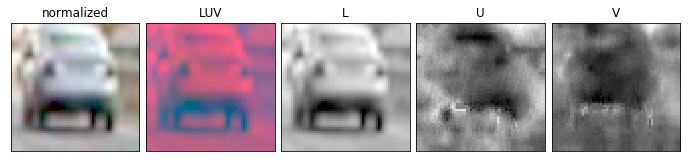

In [12]:
LUV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2LUV)
L,U,V = split_layers(LUV)
plot_images((bgr2rgb(img_norm), LUV, L,U,V),
           titles=('normalized', 'LUV', 'L', 'U','V'))

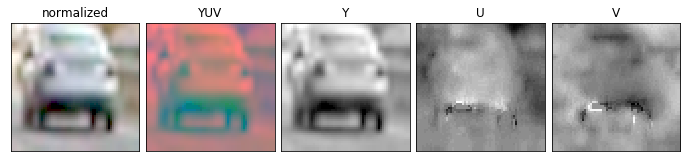

In [13]:
YUV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2YUV)
YUVs = split_layers(YUV)
plot_images((bgr2rgb(img_norm), YUV, *YUVs),
           titles=('normalized', 'YUV', *'YUV'))

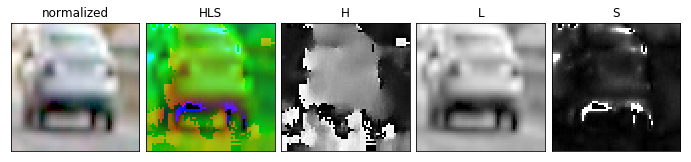

In [14]:
HLS = cv2.cvtColor(img_norm, cv2.COLOR_BGR2HLS)
H,L,S = split_layers(HLS)
plot_images((bgr2rgb(img_norm), HLS, H, L, S),
           titles=('normalized', 'HLS', 'H', 'L','S'))

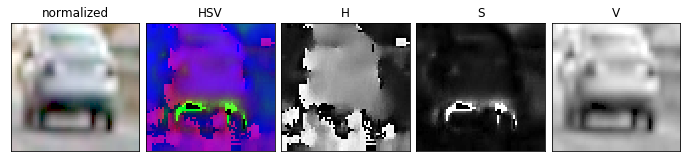

In [15]:
HSV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2HSV)
H,S,V = split_layers(HSV)
plot_images((bgr2rgb(img_norm), HSV, H,S,V),
           titles=('normalized', 'HSV', 'H', 'S','V'))

#### The only valuable channel I can see from this color sets is L(LUV), L(HLS) and V(HSV)
The rest is totally distructing

In [16]:
histograms = [np.histogram(x, bins=128, range=(0,256)) for x in [L,U,V]]
titles = ['histogram L', 'U', 'V']

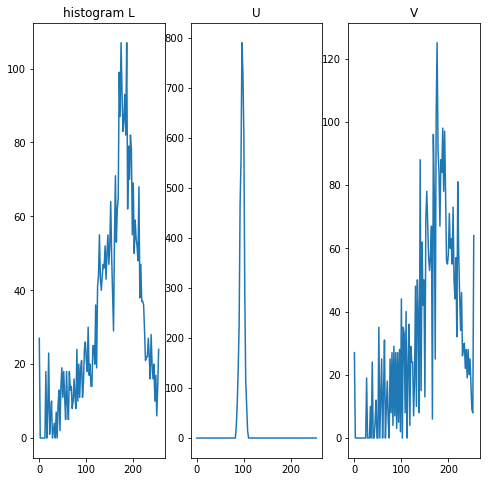

In [17]:
fig, axes = subplots(1,3, figsize=(8,8))
#fig.subplots_adjust(hspace=0.3, wspace=0.05)

for i, ax in enumerate(axes.flat):
    ax.plot(histograms[i][1][:-1], histograms[i][0])
    ax.set_title(titles[i])
show()

In [18]:
features_l, limg = hog(L, orientations=12, pixels_per_cell=(8, 8), visualise=True,
                       cells_per_block=(2,  2), transform_sqrt=False, block_norm='L2')

In [19]:
def get_hog_imgs(img, orientations=12, pixels_per_cell=8, cells_per_block=1):
    return [hog(X, orientations=orientations, 
                pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
                visualise=True,
                cells_per_block=(cells_per_block, cells_per_block), 
                transform_sqrt=False, block_norm='L2')[1] for X in split_layers(img)]

#### HOG on LUV color space

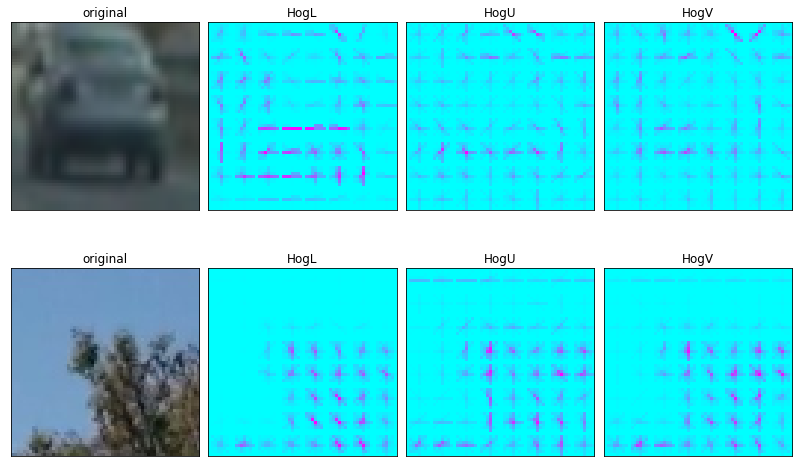

In [20]:
nv_img = cv2.imread('data/non-vehicles/Extras/extra14.png')
def prepare_img_LUV(image):
    pimg = imp.imadjust(image)
    img_norm = (np.sqrt(pimg.astype(np.float32)/255)*255).astype(np.uint8)
    LUV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2LUV)
    return LUV
nv_LUV = prepare_img_LUV(nv_img)
plot_images((bgr2rgb(img), *get_hog_imgs(LUV), 
             bgr2rgb(nv_img), *get_hog_imgs(nv_LUV)), cmap='cool', row=2, figsize=(14,8),
           titles=('original', 'HogL','HogU','HogV')*2)

#### HOG ON BGR color space

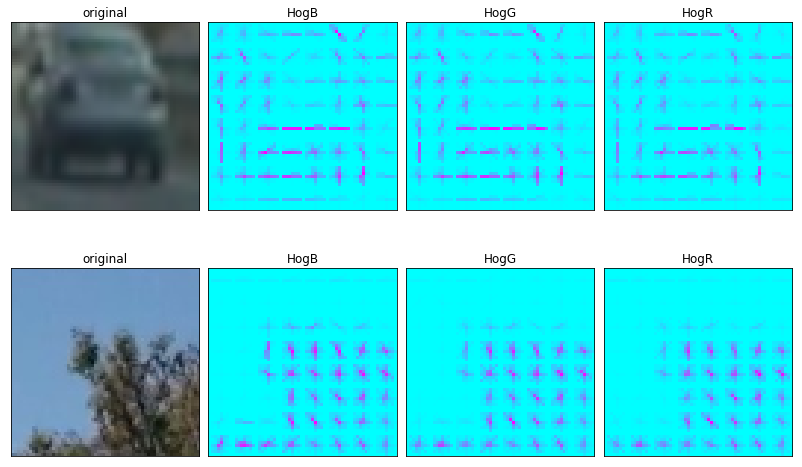

In [21]:
# hog on BGR
plot_images((bgr2rgb(img), *get_hog_imgs(img_norm), 
             bgr2rgb(nv_img), *get_hog_imgs(nv_img)), 
             cmap='cool', row=2, figsize=(14,8),
             titles=(('original', 'HogB','HogG','HogR')*2))

### Train classifier

In [22]:
im_size = (48,48)
def get_hog_features(img_layers, orientations=12, pixels_per_cell=8, cells_per_block=1):
    return [hog(X, orientations=orientations, 
                pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
                visualise=False, feature_vector=False,
                cells_per_block=(cells_per_block, cells_per_block), 
                transform_sqrt=False, block_norm='L2') for X in img_layers]

def prep_adjnorm_luv(image):
    img_adj = imp.imadjust(image)
    img_norm = (np.sqrt(img_adj.astype(np.float32)/255)*255).astype(np.uint8)
    LUV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2LUV)
    ret = LUV.astype(np.float32)/255.0
    return ret


def prep_adjnorm_hsv(image):
    img_adj = imp.imadjust(image)
    img_norm = (np.sqrt(img_adj.astype(np.float32)/255)*255).astype(np.uint8)
    HSV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2HSV)
    ret = HSV.astype(np.float32)/255.0
    return ret

def get_features(image, size=None, bins=128, range=(0.,1.), preprocess=None, hogs=None):
    if size:
        image = cv2.resize(image, size)
    img_prep = image
    if preprocess:
        img_prep = preprocess(image)
    img_tiny = cv2.resize(img_prep, (20,20))
    layers = split_layers(img_prep)
    hists = [np.histogram(x, bins=bins, range=range)[0] for x in layers]
    if hogs is None:
        hogs = get_hog_features(layers)
    h1,h2,h3 = hogs
    return np.hstack((img_tiny.ravel(),*hists, h1.ravel(), h2.ravel(), h3.ravel()))

In [23]:
features = get_features(img, (48,48), preprocess=prep_adjnorm_hsv)
print(features.shape)

(2880,)


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split

In [25]:
data_dir = 'data'
vehicles = []
non_vehicles = []
for root, subdirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('png'):
            image = cv2.imread(os.path.join(root, file))
            if 'non-vehicle' in root:
                non_vehicles.append(image)
            else:
                vehicles.append(image)
print('cars: {}, non-cars: {}'.format(len(vehicles), len(non_vehicles)))

cars: 8792, non-cars: 8968


In [26]:
features = []
labels = []
y = []
for img in (vehicles):
    try:
        features.append(get_features(img, (48,48), preprocess=prep_adjnorm_hsv))
        labels.append(1)
        y.append([1,0])
    except:
        pass

for img in (non_vehicles):
    try:
        features.append(get_features(img, (48,48), preprocess=prep_adjnorm_hsv))
        labels.append(0)
        y.append([0,1])
    except:
        pass

In [27]:
X = np.array(features, dtype=np.float32)
Y = np.array(labels, dtype=np.ubyte)
Yc = np.array(y, dtype=np.ubyte)

In [28]:
scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)

In [29]:
print(np.max(X), np.max(scaled_X))

2243.0 84.4008


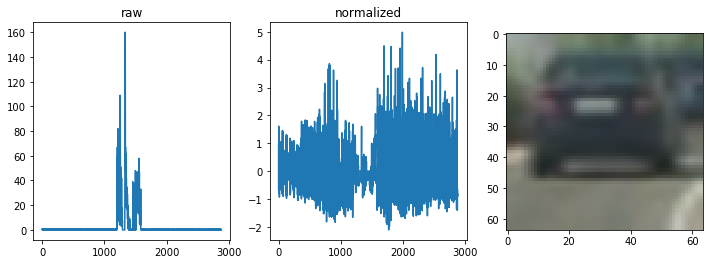

In [30]:
fig, axes = subplots(1,3, figsize=(12,4))
#fig.subplots_adjust(hspace=0.3, wspace=0.05)

ax1, ax2, ax3 = axes.flat
ax1.plot(X[0])
ax1.set_title('raw')
ax2.plot(scaled_X[0])
ax2.set_title('normalized')
ax3.imshow(bgr2rgb(vehicles[1]))
show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.10, random_state=40)

In [32]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(15979, 2880) (1776, 2880)
(15979,) (1776,)


In [33]:
cls = LinearSVC(C=1e-4, dual=False, max_iter=5)
cls.fit(X_train, y_train)
result = cls.predict(X_test)

In [34]:
true = y_test == 1
test_len = len(y_test)
positive = result == 1
true_positive = np.sum(true & positive)
true_negative = np.sum(true & np.logical_not(positive))
false_negative = np.sum(np.logical_not(true) & np.logical_not(positive))
false_positive = np.sum(np.logical_not(true) & positive)
print("TP {0:5.2f}, TN {1:5.2f}\nFN {2:5.2f}, FP {3:5.2f}".format(
    float(true_positive)/test_len, 
    float(true_negative)/test_len,                                        
    float(false_negative)/test_len, 
    float(false_positive)/test_len))
score = cls.score(X_test, y_test)
print('score:', score)

TP  0.48, TN  0.01
FN  0.52, FP  0.00
score: 0.990990990991


In [35]:
data = {'scaler': scaler,
        'classifier': cls}

pickle.dump(data, open('classifier.p', 'wb'))

## Finding cars on image

In [ ]:
with open('classifier.p', 'rb') as f:
    data = pickle.load(f)

In [36]:
img = cv2.imread(test_data_path + 'test1.jpg')

In [37]:
def get_pic_area(image, search_area=[350, 650, 0, img.shape[1]]):
    return image[search_area[0]:search_area[1], 
                 search_area[2]:search_area[3]]
cropped = get_pic_area(img)

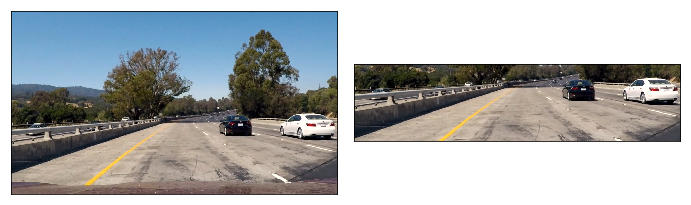

In [38]:
plot_images((img, cropped), im_prep=bgr2rgb)

### Sliding window

In [39]:
from skimage.transform import pyramid_gaussian

In [40]:
def sliding_window(image, stepSize, windowSize, padding=False):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            h = windowSize[1]
            w = windowSize[0]
            cimg = image[y:y+h, x:x+w]
            if padding:
                hn,wn = cimg.shape[:2]
                if (hn < h):
                    cimg = np.vstack((cimg, np.zeros((h-hn, wn, 3), dtype=np.ubyte)))
                if (wn < w):
                    cimg = np.hstack((cimg, np.zeros((h, w-wn, 3), dtype=np.ubyte)))
            yield (x, y, cimg)

In [41]:
import random

In [42]:
pl = img.copy()
ims=[]
win = 48
for x, y, im in sliding_window(img, win, (win,win)):
    ims.append(im)
    cv2.rectangle(pl, (x,y), (x+win, y+win), [random.randint(0,255) for _ in range(3)], 3)

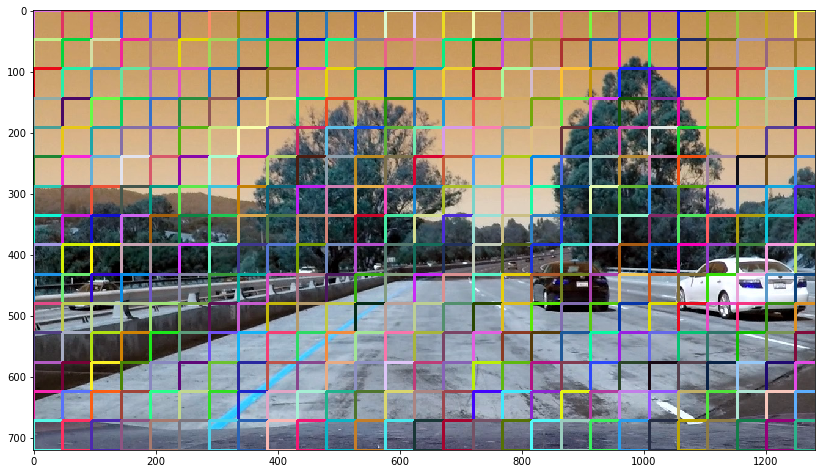

In [43]:
imshow(pl)

In [44]:
# Check pyramid images shapes
for (i, resized) in enumerate(pyramid_gaussian(cropped, downscale=1.3, max_layer=7, order=1 )):
    print(resized.shape)

(300, 1280, 3)
(231, 985, 3)
(178, 758, 3)
(137, 584, 3)
(106, 450, 3)
(82, 347, 3)
(64, 267, 3)
(50, 206, 3)


In [45]:
def get_points(img, simg, pt1, pt2):
    """
    finds the scale of simg agains img
    returns (pt1, pt2) * scale
    """
    ky = img.shape[0]/simg.shape[0]
    kx = img.shape[1]/simg.shape[1]
    k = np.array([kx, ky])
    rt1 = (np.array(pt1)*k).astype(np.uint).tolist()
    rt2 = (np.array(pt2)*k).astype(np.uint).tolist()
    return (tuple(rt1), tuple(rt2))

### Trying to slide window over set of rescaled images

In [46]:
ws_features = []
ws = []
prep_image = prep_adjnorm_hsv(cropped)
win = 48
for i, rimg in enumerate(pyramid_gaussian(prep_image, downscale=1.3, max_layer=6)):
    if (i < 2): # skip first to pics to avoid to small windows
        continue
    for window in sliding_window(rimg, int(0.75*win), (win,win)):
        if window[2].shape[:2] == (win, win):
            pt1, pt2 = get_points(prep_image, rimg, window[:2],(window[0]+win, window[1]+win))
            ws.append((pt1,pt2))
            wimg = window[2].astype(np.float32)
            ws_features.append(get_features(wimg))
print(len(ws))

165


In [47]:
scaled_X = scaler.transform(ws_features)

result = cls.predict(scaled_X)

wsa = np.array(ws)

cars = wsa[result==1]

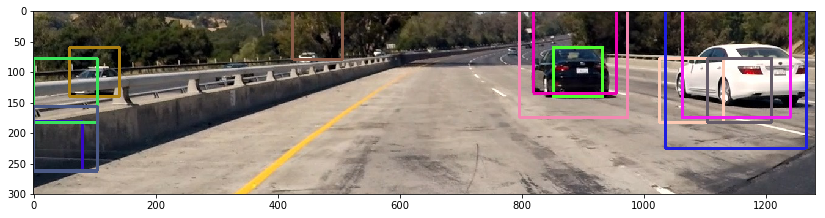

In [49]:
img = cropped
pl = img.copy()
for box in cars:
    pt1, pt2 = tuple(map(tuple, box))
    cv2.rectangle(pl, pt1, pt2, [random.randint(0,255) for _ in range(3)], 3)
imshow(bgr2rgb(pl))

In [50]:
heatmap = np.zeros(cropped.shape[:2], dtype=np.ubyte)

In [51]:
for box in cars:
    pt1, pt2 = tuple(map(tuple, box))
    heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1

In [52]:
heatmap[heatmap<2]=0

In [53]:
from scipy.ndimage.measurements import label
labels = label(heatmap)

4 cars found


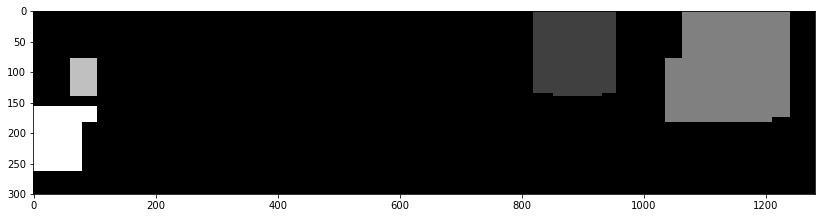

In [54]:
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

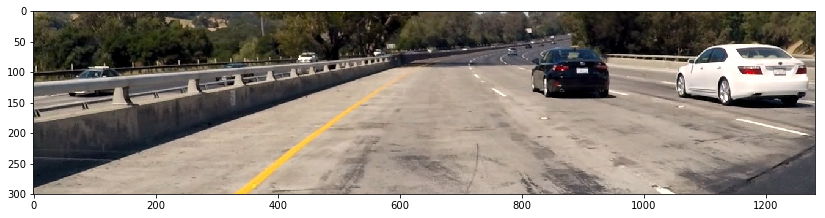

In [55]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)+350), (np.max(nonzerox), np.max(nonzeroy)+350))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
bimg = draw_labeled_bboxes(img.copy(), labels)
imshow(bgr2rgb(bimg))

In [56]:
def pipeline(image):
    ws_features = []
    ws = []
    cropped = get_pic_area(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    prep_image = prep_adjnorm_hsv(cropped)
    win = 48
    for i, rimg in enumerate(pyramid_gaussian(prep_image, downscale=1.3, max_layer=6)):
        if (i < 1): # skip first to pics to avoid to small windows
            continue
        for window in sliding_window(rimg, int(0.75*win), (win,win)):
            if window[2].shape[:2] == (win, win):
                pt1, pt2 = get_points(prep_image, rimg, window[:2],(window[0]+win, window[1]+win))
                ws.append((pt1,pt2))
                wimg = window[2].astype(np.float32)
                ws_features.append(get_features(wimg))
    scaled_X = scaler.transform(ws_features)
    result = cls.predict(scaled_X)
    wsa = np.array(ws)
    cars = wsa[result==1]
    heatmap = np.zeros(cropped.shape[:2], dtype=np.ubyte)
    for box in cars:
        pt1, pt2 = tuple(map(tuple, box))
        heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1
        
    heatmap[heatmap<2] = 0
    labels = label(heatmap)
    bimg = draw_labeled_bboxes(image.copy(), labels)
    return bimg

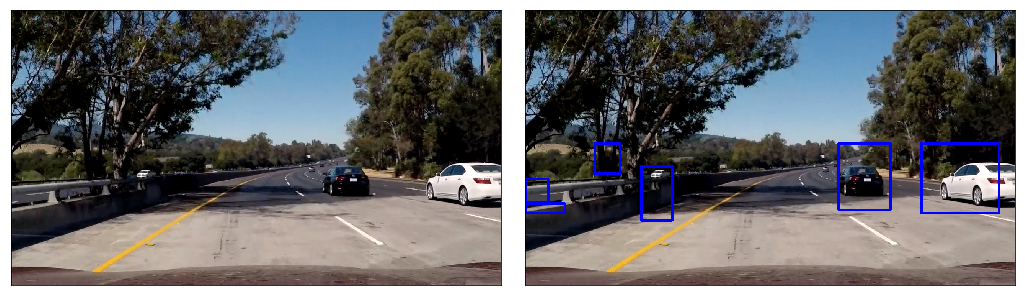

In [57]:
img = imread('./test_images/test5.jpg')

plot_images((img, pipeline(img)), figsize=(18,16))

## NN classification

In [58]:
import keras

Using TensorFlow backend.


In [59]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Lambda, Input
from keras.optimizers import SGD
from keras.layers.advanced_activations import ELU
from keras.callbacks import LearningRateScheduler, EarlyStopping

In [60]:
from keras.layers import BatchNormalization

from keras import initializers

In [61]:
model = keras.models.Sequential()
winit = initializers.TruncatedNormal(stddev=0.05)
model.add(Dense(X_train.shape[1], activation='relu', input_shape=X_train.shape[1:], kernel_initializer=winit))
model.add(Dropout(0.6))
model.add(Dense(2000, activation='relu', kernel_initializer=winit))
model.add(Dense(3000, activation='relu', kernel_initializer=winit))
model.add(Dense(512, activation='elu'))
model.add(Dense(2, activation='softmax'))

In [62]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [65]:
Xt = scaler.transform(X)
Xt = Xt / np.max(Xt)

In [66]:
model.fit(Xt, Yc, 
         validation_split=0.1, shuffle=True, 
         epochs=20, batch_size=128,
         verbose=2)

Train on 15979 samples, validate on 1776 samples
Epoch 1/20
11s - loss: 0.0846 - acc: 0.9657 - val_loss: 0.0930 - val_acc: 0.9679
Epoch 2/20
9s - loss: 0.0070 - acc: 0.9978 - val_loss: 0.0539 - val_acc: 0.9859
Epoch 3/20
9s - loss: 0.0065 - acc: 0.9979 - val_loss: 0.0481 - val_acc: 0.9825
Epoch 4/20
9s - loss: 0.0044 - acc: 0.9986 - val_loss: 0.0701 - val_acc: 0.9786
Epoch 5/20
9s - loss: 0.0067 - acc: 0.9976 - val_loss: 0.0890 - val_acc: 0.9690
Epoch 6/20
9s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.1088 - val_acc: 0.9673
Epoch 7/20
9s - loss: 0.0027 - acc: 0.9989 - val_loss: 0.1210 - val_acc: 0.9713
Epoch 8/20
9s - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0680 - val_acc: 0.9837
Epoch 9/20
9s - loss: 0.0044 - acc: 0.9987 - val_loss: 0.0538 - val_acc: 0.9854
Epoch 10/20
9s - loss: 0.0040 - acc: 0.9985 - val_loss: 0.1012 - val_acc: 0.9741
Epoch 11/20
9s - loss: 5.3738e-04 - acc: 0.9998 - val_loss: 0.1498 - val_acc: 0.9780
Epoch 12/20
9s - loss: 0.0032 - acc: 0.9988 - val_loss: 0.0763 -

In [88]:
def pipeline2(image):
    ws_features = []
    ws = []
    cropped = get_pic_area(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    prep_image = prep_adjnorm_hsv(cropped)
    win = 48
    for i, rimg in enumerate(pyramid_gaussian(prep_image, downscale=1.3, max_layer=6)):
        if (i < 2): # skip first to pics to avoid to small windows
            continue
        for window in sliding_window(rimg, int(0.5*win), (win,win)):
            if window[2].shape[:2] == (win, win):
                pt1, pt2 = get_points(prep_image, rimg, window[:2],(window[0]+win, window[1]+win))
                ws.append((pt1,pt2))
                wimg = window[2].astype(np.float32)
                ws_features.append(get_features(wimg))
    #scaled_X = np.array(ws_features, dtype=np.float32) / np.max(X)
    scaled_X = scaler.transform(ws_features)
    scaled_X = scaled_X / np.max(Xt)
    result = model.predict(scaled_X)
    wsa = np.array(ws)
    cars = wsa[np.argmin(result, axis=1)==1]
    heatmap = np.zeros(cropped.shape[:2], dtype=np.ubyte)
    for box in cars:
        pt1, pt2 = tuple(map(tuple, box))
        heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1
        
    heatmap[heatmap<2] = 0
    labels = label(heatmap)
    bimg = draw_labeled_bboxes(image.copy(), labels)
    return bimg

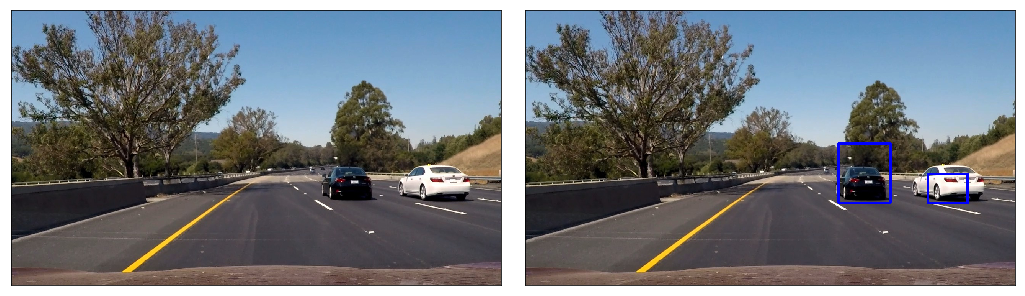

In [89]:
img = imread('./test_images/test6.jpg')

plot_images((img, pipeline2(img)), figsize=(18,16))

In [83]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'project_video_out_nn.mp4'
clip1 = VideoFileClip("../Advanced-Lane-Lines/project_video.mp4")
white_clip = clip1.fl_image(pipeline2)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out_nn.mp4
[MoviePy] Writing video project_video_out_nn.mp4



  5%|████▎                                                                           | 67/1261 [01:46<30:28,  1.53s/it]


  8%|██████                                                                          | 95/1261 [02:32<32:03,  1.65s/it]

## Trying pretrained model
### YOLO (YouOnlyLookOnce)
https://pjreddie.com/darknet/yolo/

https://github.com/allanzelener/YAD2K

In [ ]:
import keras

In [ ]:
model = keras.models.load_model('model_data/yolo.h5')

In [ ]:
import colorsys
import imghdr
from yad2k.models.keras_yolo import yolo_eval, yolo_head
from keras import backend as K

In [ ]:
anchors_path = 'model_data/yolo_anchors.txt'
classes_path = 'model_data/coco_classes.txt'

with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

yolo_model = model

# Verify model, anchors, and classes are compatible
num_classes = len(class_names)
num_anchors = len(anchors)

model_output_channels = yolo_model.layers[-1].output_shape[-1]

# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]

# Generate output tensor targets for filtered bounding boxes.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=0.4,
    iou_threshold=0.4)

In [ ]:
sess = K.get_session() 

In [ ]:
font = cv2.FONT_HERSHEY_COMPLEX
#        cv2.putText(ret, curvl, (0, ret.shape[0]-textSize[1]), font, 1, (255, 0, 0), 2)

def process(img):
    image = cv2.resize(bgr2rgb(img), model_image_size)
    image_data =  image.astype(np.float32)

    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    #img = image
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.shape[1], image.shape[0]],
            K.learning_phase(): 0
        })
    #print('Found {} boxes '.format(len(out_boxes)))

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))
        pt1 = (left, top)
        pt2 = (right, bottom)
        pt1, pt2 = get_points(img, image, pt1, pt2)
        cv2.rectangle(img, pt1, pt2, [0, 255, 0], 2)        
         
        #textSize,_ = cv2.getTextSize(label, font, 1, 2)
        #cv2.putText(img, label, (pt1[0], pt1[1]-textSize[1]), font, 1, (255, 0, 0), 2)
    return img

In [ ]:
imshow(bgr2rgb(process(img.copy())))

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("../Advanced-Lane-Lines/project_video.mp4")
white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(white_output, audio=False)